In [20]:
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import seaborn.objects as so
import seaborn as sns
import pandas as pd

import bambi as bmb
from bambi.plots import plot_comparison

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### mtcars

In [14]:
# Load data
data = bmb.load_data('mtcars')
data["cyl"] = data["cyl"].replace({4: "low", 6: "medium", 8: "high"})
data["gear"] = data["gear"].replace({3: "A", 4: "B", 5: "C"})
data["cyl"] = pd.Categorical(data["cyl"], categories=["low", "medium", "high"], ordered=True)
data["am"] = pd.Categorical(data["am"], categories=[0, 1], ordered=True)
#data["drat"] = pd.Categorical(data["drat"], ordered=True).codes

In [15]:
# Define and fit the Bambi model
model = bmb.Model("mpg ~ hp * drat * am", data)
idata = model.fit(draws=1000, target_accept=0.95, random_seed=1234)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mpg_sigma, Intercept, hp, drat, hp:drat, am, hp:am, drat:am, hp:drat:am]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


In [229]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.557,0.592,0.455,2.658,0.014,0.010,1898.0,2500.0,1.0
PClass[2.0],0.188,0.904,-1.491,1.885,0.022,0.016,1594.0,2342.0,1.0
PClass[3.0],-2.038,0.776,-3.495,-0.588,0.018,0.013,1795.0,2306.0,1.0
SexCode[1],1.090,1.238,-1.199,3.418,0.036,0.026,1201.0,1871.0,1.0
"PClass:SexCode[2.0, 1]",0.176,1.644,-2.901,3.206,0.047,0.033,1212.0,2053.0,1.0
"PClass:SexCode[3.0, 1]",-0.801,1.381,-3.434,1.792,0.040,0.028,1245.0,1785.0,1.0
Age,-0.056,0.015,-0.082,-0.027,0.000,0.000,1856.0,2411.0,1.0
PClass:Age[2.0],-0.090,0.033,-0.156,-0.030,0.001,0.001,1749.0,2195.0,1.0
PClass:Age[3.0],0.003,0.025,-0.044,0.049,0.001,0.000,1935.0,2673.0,1.0
SexCode:Age[1],0.069,0.032,0.010,0.128,0.001,0.001,1318.0,1865.0,1.0


Like `plot_cap` the user must also pass the `model` and `idata`. However, for `plot_comparisons`, the user needs to pass a `contrast_predictor` and `conditional` argument. `contrast_predictor` is the variable whose contrast we are interested in computing comparisons (the difference between predictions) for. `conditional` is the variable that we are conditioning on.

Currently, the `plot_comparisons` function allows the user to pass either `str`, `list`, or `dict` into `contrast_predictor` and `conditional`. A `dict` is used to compare predictions of user defined contrasts. I think this data structure is a good representation since the key, value pair reads as "predictor" : "contrast". If a `str` or `list` is passed, the function will use a grid based on the observed data.

To compute the contrasts, the cartesion product (cross join) is used to compute all pairwise combinations of the `contrast_predictor` and `conditional` variables which is stored as a dataframe. This dataframe, like the `create_cap_data` dataframe, is used as the new data for the model to perform predictions. To compute the difference in predictions (comparison) of the contrasts, multiple pandas methods are chained:
1. `.groupby()` is used to group the dataframe by the covariates in the model (excluding the contrast predictor)
2. `.diff()` is used to compute the difference between the predictions of the contrasts
3. `.dropna()` is used to remove the first row of each group since the difference is computed between the current row and the previous row
4. `.reset_index()` is used to reset the index of the dataframe

The result of steps 1-4 are saved in a new dataframe—`contrast_comparison`. Conditional variable values are added to the dataframe and the dataframe is passed to `plot_comparison` to plot the comparisons.

contrast_predictor: {'hp': [110, 175]}
main: am, group: drat, panel: None
model covariates: ['am', 'drat']
HERE


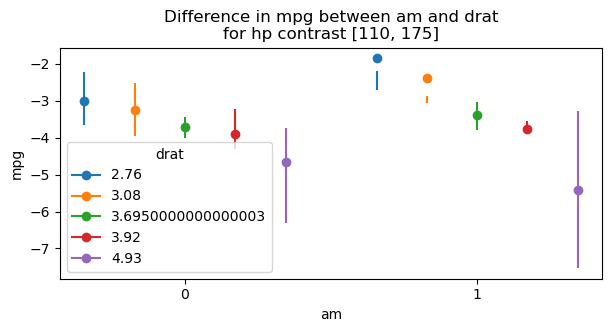

In [21]:
# user defined contrast for `hp`
# grid is determined for `am` and `drat`
# HDI does not include the mean contrast comparison...
fig, ax, comparisons_df, contrast_df, idata_new = plot_comparison(
    model,
    idata,
    contrast_predictor={"hp": [110, 175]},
    conditional=["am", "drat"]
)
fig.set_size_inches(7, 3)
plt.title("Difference in mpg between am and drat\nfor hp contrast [110, 175]");

contrast_predictor: hp
main: am, group: drat, panel: None
model covariates: ['am', 'drat']
HERE


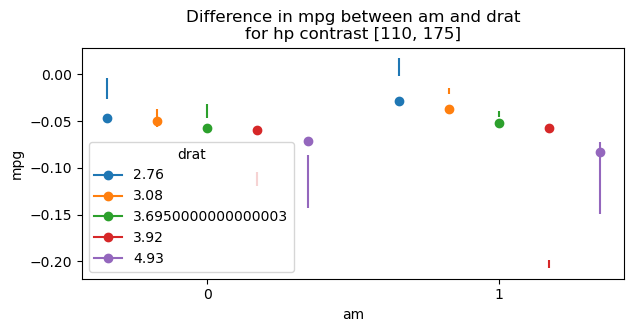

In [17]:
# HDI does not include the mean contrast comparison...
fig, ax, comparisons_df, contrast_df, idata_new = plot_comparison(
    model,
    idata,
    contrast_predictor="hp",
    conditional=["am", "drat"]
)
fig.set_size_inches(7, 3)
plt.title("Difference in mpg between am and drat\nfor hp contrast [110, 175]");

### Palmer penguins

In [22]:
data = pd.read_csv("https://vincentarelbundock.github.io/Rdatasets/csv/palmerpenguins/penguins.csv", index_col=0)
data = data.dropna(axis=0, how="any")

In [23]:
model = bmb.Model(
    "body_mass_g ~ flipper_length_mm * species * bill_length_mm + island",
    data, family="gaussian"
)
idata = model.fit(draws=1000, target_accept=0.95, random_seed=1234)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [body_mass_g_sigma, Intercept, flipper_length_mm, species, flipper_length_mm:species, bill_length_mm, flipper_length_mm:bill_length_mm, species:bill_length_mm, flipper_length_mm:species:bill_length_mm, island]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 147 seconds.


In [24]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-6621.982,4994.819,-15950.763,2714.231,131.516,93.015,1442.0,2000.0,1.0
flipper_length_mm,39.260,26.228,-8.793,88.782,0.691,0.488,1441.0,2043.0,1.0
species[Chinstrap],358.032,2530.608,-4014.266,5460.335,60.581,42.844,1753.0,2431.0,1.0
species[Gentoo],-1941.339,2334.832,-6366.018,2371.530,57.724,41.311,1640.0,2117.0,1.0
flipper_length_mm:species[Chinstrap],3.917,13.561,-21.860,28.714,0.322,0.228,1772.0,2432.0,1.0
flipper_length_mm:species[Gentoo],10.627,10.799,-10.355,29.883,0.243,0.172,1964.0,2438.0,1.0
bill_length_mm,146.651,124.190,-77.265,382.820,3.329,2.354,1393.0,1808.0,1.0
flipper_length_mm:bill_length_mm,-0.380,0.648,-1.628,0.784,0.017,0.012,1383.0,1836.0,1.0
species:bill_length_mm[Chinstrap],-51.932,55.145,-157.283,48.558,1.328,0.939,1725.0,2259.0,1.0
species:bill_length_mm[Gentoo],-18.541,49.308,-110.659,73.099,1.159,0.820,1817.0,2149.0,1.0


contrast_predictor: ['flipper_length_mm']
main: bill_length_mm, group: species, panel: None
model covariates: ['bill_length_mm', 'species', 'island']
HERE


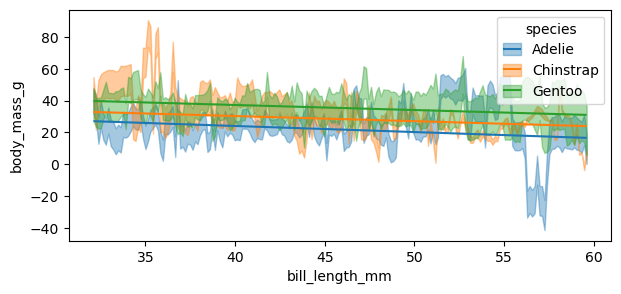

In [26]:
fig, ax, comparisons_df, contrast_df, idata_new = plot_comparison(
    model=model,
    idata=idata,
    contrast_predictor=["flipper_length_mm"],
    conditional=["bill_length_mm", "species"]
)
fig.set_size_inches(7, 3)

In [27]:
# HDI does not include the mean contrast comparison...
contrast_df

,contrast_comparison,contrast_comparison_lower,contrast_comparison_upper,bill_length_mm,species
0,27.068395,31.656234,47.725210,32.100000,Adelie
1,32.841295,36.742993,54.692950,32.100000,Chinstrap
2,39.724979,47.558343,27.397502,32.100000,Gentoo
3,27.015909,27.670022,43.843105,32.238191,Adelie
4,32.796798,21.727677,38.872678,32.238191,Chinstrap
...,...,...,...,...,...
595,24.030917,-3.644115,-0.958556,59.461809,Chinstrap
596,31.062888,44.355995,13.978242,59.461809,Gentoo
597,16.623552,0.342328,19.052322,59.600000,Adelie
598,23.986420,5.776226,8.969351,59.600000,Chinstrap


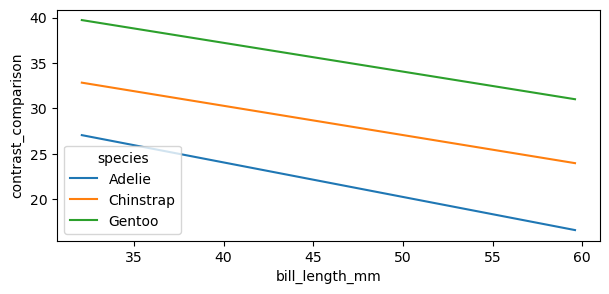

In [28]:
# should be???
plt.figure(figsize=(7, 3))
sns.lineplot(
    data=contrast_df,
    x="bill_length_mm",
    y="contrast_comparison",
    hue="species"
);

contrast_predictor: {'flipper_length_mm': [172, 231]}
main: island, group: species, panel: None
model covariates: ['island', 'species', 'bill_length_mm']


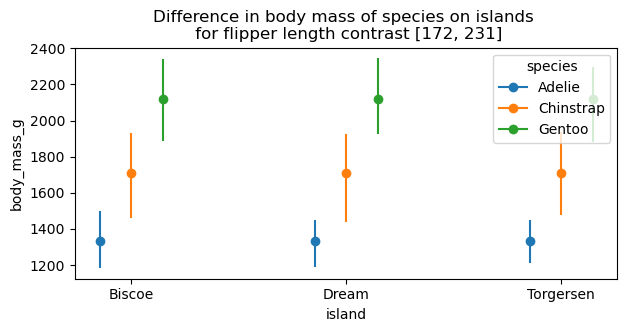

In [203]:
fig, ax, comparisons_df, contrast_df, idata  = plot_comparison(
    model=model,
    idata=idata,
    contrast_predictor={"flipper_length_mm": [172, 231]},
    conditional=["island", "species"]
)
fig.set_size_inches(7, 3)
plt.title("Difference in body mass of species on islands \n for flipper length contrast [172, 231]");

### Titanic

In [204]:
dat = pd.read_csv("https://vincentarelbundock.github.io/Rdatasets/csv/Stat2Data/Titanic.csv", index_col=0)

In [205]:
dat["PClass"] = dat["PClass"].str.replace("[st, nd, rd]", "", regex=True)
dat["PClass"] = dat["PClass"].str.replace("*", "0").astype(int)
dat["PClass"] = dat["PClass"].replace(0, np.nan)
dat["PClass"] = pd.Categorical(dat["PClass"], ordered=True)
dat["SexCode"] = pd.Categorical(dat["SexCode"], ordered=True)

In [206]:
dat = dat.dropna(axis=0, how="any")

In [207]:
titanic_model = bmb.Model(
    "Survived ~ PClass * SexCode * Age", 
    data=dat, 
    family="bernoulli"
)

titanic_idata = titanic_model.fit(draws=1000, target_accept=0.95, random_seed=1234)

Modeling the probability that Survived==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, PClass, SexCode, PClass:SexCode, Age, PClass:Age, SexCode:Age, PClass:SexCode:Age]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


contrast_predictor: {'Age': [50, 70]}
main: SexCode, group: None, panel: None
model covariates: ['SexCode', 'PClass']


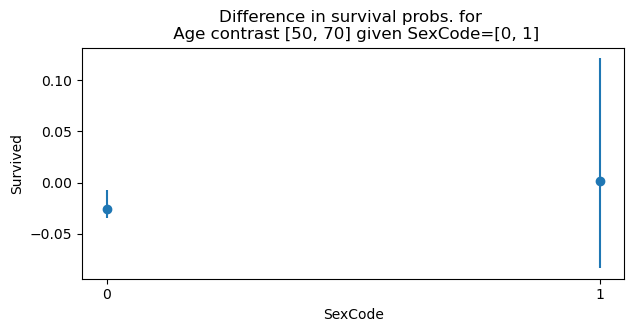

In [208]:
fig, ax, comparisons_df, contrast_df, idata = plot_comparison(
    model=titanic_model,
    idata=titanic_idata,
    contrast_predictor={"Age": [50, 70]},
    conditional="SexCode"
)
fig.set_size_inches(7, 3)
plt.title("Difference in survival probs. for \n Age contrast [50, 70] given SexCode=[0, 1]");

contrast_predictor: {'PClass': [1, 3]}
main: Age, group: SexCode, panel: None
model covariates: ['Age', 'SexCode']


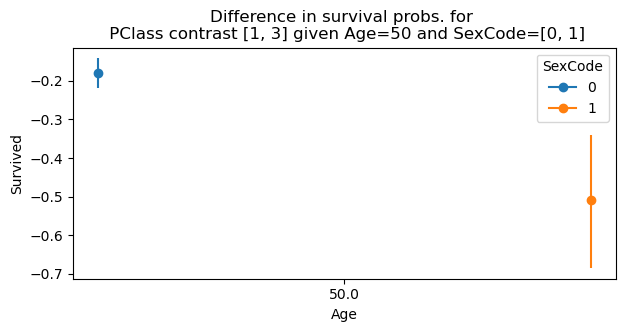

In [209]:
# user can also pass a dict into conditional to define the 
# values used for the conditional variables
fig, ax, comparisons_df, contrast_df, idata = plot_comparison(
    model=titanic_model,
    idata=titanic_idata,
    contrast_predictor={"PClass": [1, 3]},
    conditional={"Age": [50], "SexCode": [0, 1]}
)
fig.set_size_inches(7, 3)
plt.title("Difference in survival probs. for \n PClass contrast [1, 3] given Age=50 and SexCode=[0, 1]");